# 5차 Submission
Augmentation
- Tabular GANs

PyCaret 결과 바탕

- model1 : 정적 동적 구분 () - Extra Trees Classifier
- model2-1 : 정적으로 구분한 것을 세부 Class 분류 - LGBM
- model2-1 : 동적으로 구분한 것을 세부 Class 분류 - LGBM

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install tabgan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 데이터 확인

In [36]:
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
import tensorflow as tf
import numpy as np
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [38]:
# data 확인
# train_path = 'data/train_dataset.csv'
# test_path = 'data/test_dataset.csv'
train_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/train_dataset.csv'
test_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/test_dataset.csv'

train_data = pd.read_csv(train_path)
x_test = pd.read_csv(test_path)

train_data.shape, x_test.shape

((5881, 52), (1471, 50))

- Dynamic : 0, 1, 2 (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS)
- Static : 3, 4, 5 (LAYING, STANDING, SITTING)

## Target 분포 확인

In [39]:
train_data['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

<Axes: >

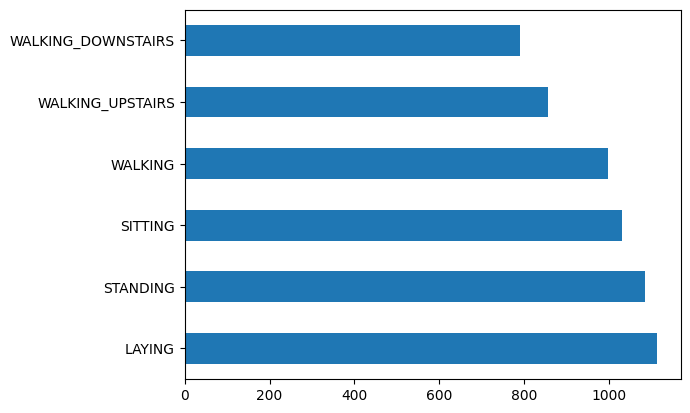

In [40]:
train_data['Activity'].value_counts().plot(kind='barh')

## Augmentation

In [41]:
# x, y 분리
x = train_data.drop(['Activity', 'Activity_dynamic'], axis=1)
y = train_data[['Activity_dynamic']]

In [42]:
orig_cols = list(x)
x.columns = list(range(50))
x_test.columns = list(range(50))

In [43]:
%%time
from tqdm.autonotebook import tqdm
from tabgan.sampler import GANGenerator

new_x, new_y = GANGenerator().generate_data_pipe(x, y, x_test, )

Fitting CTGAN transformers for each column:   0%|          | 0/51 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecat

CPU times: user 4min 3s, sys: 26.8 s, total: 4min 29s
Wall time: 4min 9s


In [52]:
temp_x = new_x.copy()

In [54]:
temp_x.columns = orig_cols
temp_x['Activity_dynamic'] = new_y

In [57]:
save_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/augmented_data.csv'
temp_x.to_csv(save_path, index=False)

In [75]:
train_data = x.copy()

In [76]:
train_data['Activity_dynamic'] = y

In [78]:
temp_x['Activity_dynamic'] = new_y

In [81]:
train_data = pd.concat([train_data, temp_x])

In [82]:
train_data.shape

(11123, 51)

In [85]:
train_data.columns = orig_cols + ['Activity_dynamic']

In [87]:
save_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/augmented_data_concat.csv'
train_data.to_csv(save_path, index=False)

# 모델링

In [88]:
# x, y 분리
x = train_data.drop('Activity_dynamic', axis=1).values
y = train_data['Activity_dynamic'].values

In [89]:
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score

## is_dynamic 분류
- PyCaret 결과 : Extra Trees Classifier가 가장 좋았음

In [90]:
train_data['is_dynamic'] = np.where(train_data['Activity_dynamic'] < 3, 1, 0)

In [91]:
y_is_dy = train_data['is_dynamic'].values

In [92]:
from sklearn.ensemble import ExtraTreesClassifier

my_seed_everywhere(42)
model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)
# 검증하기
cv_score = cross_val_score(model, x, y_is_dy, cv=10)

# 확인
print(cv_score)
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.99910153 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
평균: 0.9999101527403415
표준편차: 0.00026954177897574593


In [93]:
# model1은 is_dynamic 분류 모델
my_seed_everywhere(42)
model1 = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)
model1.fit(x, y_is_dy)

ExtraTreesClassifier(n_jobs=-1, random_state=42)

## 정적 Class 분류
- LGBM이 성능이 좋았음.
- LGBM을 사용할 때는, label 값이 0부터 시작해야함.
- 따라서 정적 class의 경우 3~5로 존재하는 것을 -3을 해서 0~1으로 바꿔줘야함
- 그러므로 결과를 낼때 +3 을 해줘야함

In [94]:
static_data = train_data[train_data['is_dynamic'] == 0].reset_index(drop=True)
x_static = static_data.drop(columns=['Activity_dynamic', 'is_dynamic']).values
y_static = static_data['Activity_dynamic'].values

In [95]:
from lightgbm import LGBMClassifier
my_seed_everywhere(42)
model = LGBMClassifier(random_state=42)
# 검증하기
cv_score = cross_val_score(model, x_static, y_static-3, cv=10)

# 확인
print(cv_score)
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.96895425 0.97058824 0.97712418 0.96078431 0.97385621 0.96078431
 1.         0.99673203 0.99836334 1.        ]
평균: 0.9807186868200635
표준편차: 0.015514829790628787


In [96]:
# model2_1은 정적 Class 분류
my_seed_everywhere(42)
model2_1 = LGBMClassifier(random_state=42)

model2_1.fit(x_static, y_static-3)

LGBMClassifier(random_state=42)

## 동적 Class 분류
- 마찬가지로 LGBM

In [97]:
dynamic_data = train_data[train_data['is_dynamic'] == 1].reset_index(drop=True)
x_dynamic = dynamic_data.drop(columns=['Activity_dynamic', 'is_dynamic']).values
y_dynamic = dynamic_data['Activity_dynamic'].values

In [98]:
my_seed_everywhere(42)
model = LGBMClassifier(random_state=42)
# 검증하기
cv_score = cross_val_score(model, x_dynamic, y_dynamic, cv=10)

# 확인
print(cv_score)
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.98602794 0.99001996 0.99001996 0.99201597 0.98802395 0.978
 1.         1.         1.         1.        ]
평균: 0.9924107784431137
표준편차: 0.007138826166290501


In [99]:
# model2_2 는 동적 Class 분류
my_seed_everywhere(42)
model2_2 = LGBMClassifier(random_state=42)
model2_2.fit(x_dynamic, y_dynamic)

LGBMClassifier(random_state=42)

In [100]:
model2_1.predict( x_test ) + 3

array([5, 4, 3, ..., 3, 3, 4])

In [101]:
def my_model_predict(x):
    """
    params:
        x : DataFrame. Features
    ret:
        y_pred : numpy array

    model1 : 정적 동적 구분 
    model2-1 : 정적으로 구분한 것을 세부 Class 분류 
    model2-1 : 동적으로 구분한 것을 세부 Class 분류 
    """
    # 정적, 동적 예측 결과 저장
    x['is_dynamic'] = model1.predict(x.values)

    # 정적과 동적 예측 결과에 따라 나누기
    # reset_index로 원래의 index 를 column으로 빼서 나중에 concat 후 사용
    temp_static = x[x['is_dynamic'] == 0].reset_index()
    temp_dynamic = x[x['is_dynamic'] == 1].reset_index()

    # 정적, 동적 별로 각 Class 예측
    # 정적 Class 는 결과값 + 3!!
    temp_static['label'] = model2_1.predict( temp_static.drop(['is_dynamic', 'index'], axis=1) ) + 3
    temp_dynamic['label'] = model2_2.predict( temp_dynamic.drop(['is_dynamic', 'index'], axis=1) )

    # 각 예측 결과를 합치고, index로 정렬
    result_df = pd.concat([temp_static, temp_dynamic], axis=0).sort_values(by='index').set_index('index')

    # y_pred 뽑기
    y_pred = result_df['label'].values

    return y_pred

In [102]:
y_pred = my_model_predict(x_test)
y_pred

array([5, 4, 0, ..., 2, 3, 2])

In [103]:
result = pd.DataFrame(y_pred, columns=['Activity']).reset_index(names='ID')
result

,ID,Activity
0,0,5
1,1,4
2,2,0
3,3,5
4,4,4
...,...,...
1466,1466,5
1467,1467,4
1468,1468,2
1469,1469,3


In [104]:
save_path

'/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/augmented_data_concat.csv'

In [105]:
# result.to_csv("submssion_5.csv", index=False)
save_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/'
result.to_csv(save_path + "submssion_5.csv", index=False)

In [106]:
temp = pd.read_csv(save_path + 'submssion_1.csv')
(temp['Activity'] != result['Activity']).sum()

128